### Predict future loan demand or interest rates using time series analysis.

In [38]:
from fredapi import Fred
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import warnings

        Date  Interest Rate
0 1962-01-02           4.06
1 1962-01-03           4.03
2 1962-01-04           3.99
3 1962-01-05           4.02
4 1962-01-08           4.03


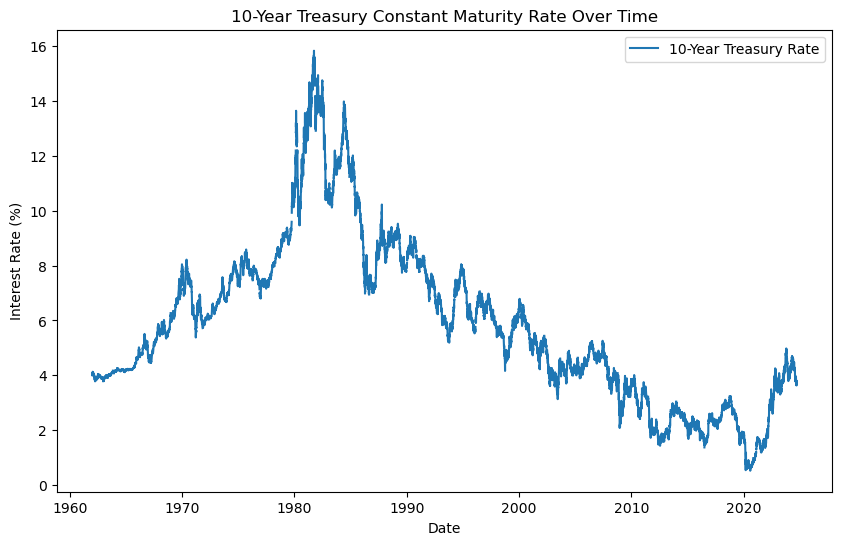

In [39]:
# Disable warnings
warnings.filterwarnings('ignore')

# Initialize Fred API with your API key
fred = Fred(api_key='dc7c3ec781759add86587b96ae2c8b0a')

# Fetch U.S. 10-Year Treasury Constant Maturity Rate (DGS10)
data = fred.get_series('DGS10')

# Convert to a pandas DataFrame
data = pd.DataFrame(data, columns=['Interest Rate'])
data.index.name = 'Date'
data.reset_index(inplace=True)

# Display first few rows of the data
print(data.head())


# Plot the interest rates over time
plt.figure(figsize=(10, 6))
plt.plot(data['Date'], data['Interest Rate'], label='10-Year Treasury Rate')
plt.title('10-Year Treasury Constant Maturity Rate Over Time')
plt.xlabel('Date')
plt.ylabel('Interest Rate (%)')
plt.legend()
plt.show()


The Augmented Dickey-Fuller (ADF) test is used to determine whether a time series is stationary, which is a key assumption for many time series forecasting models, including ARIMA. Stationarity means that the statistical properties of the series (like mean, variance) do not change over time. A low p-value (typically less than 0.05) would suggest rejecting the null hypothesis, meaning the series is stationary. In case of 10-Year Treasury Constant Maturity Rate the data is non-stationary, implying that there are trends or seasonality.

In [40]:
# Check for stationarity with ADF Test
adf_result = adfuller(data['Interest Rate'].dropna())
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')

ADF Statistic: -1.683651597947681
p-value: 0.4395547377651342


In [50]:
data.isna()

,Date,Interest Rate
0,False,False
1,False,False
2,False,False
3,False,False
4,False,False
...,...,...
16363,False,False
16364,False,False
16365,False,False
16366,False,False


#### Decomposing the Time Series
The trend component represents the long-term progression of the series, highlighting whether the data moves upwards, downwards, or stays relatively stable over time. Seasonality reflects the repeating patterns or cycles over specific intervals, such as monthly or quarterly. Finally, the residuals consist of random fluctuations that do not fit into the trend or seasonal components, often considered as ‘noise’ in the data.

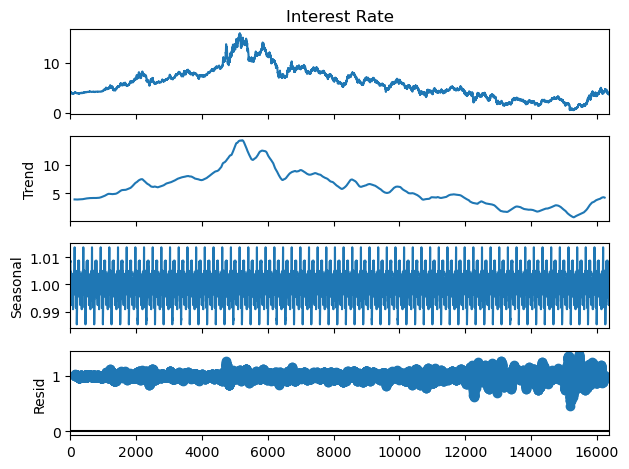

In [42]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Remove missing values from the dataset
data_clean = data.dropna()

# Apply seasonal decomposition using the cleaned data
# Use period=252 to reflect the number of trading days in a year 
result = seasonal_decompose(data_clean['Interest Rate'], model='multiplicative', period=252)

# Plot the decomposed components
result.plot()
plt.show()


#### Splitting Data for Training and Testing
We will split our data such that everything before November 2020 will serve as training data, with everything after 2020 becoming the testing data

Training data shape: (13094, 1)
Testing data shape: (3274, 1)


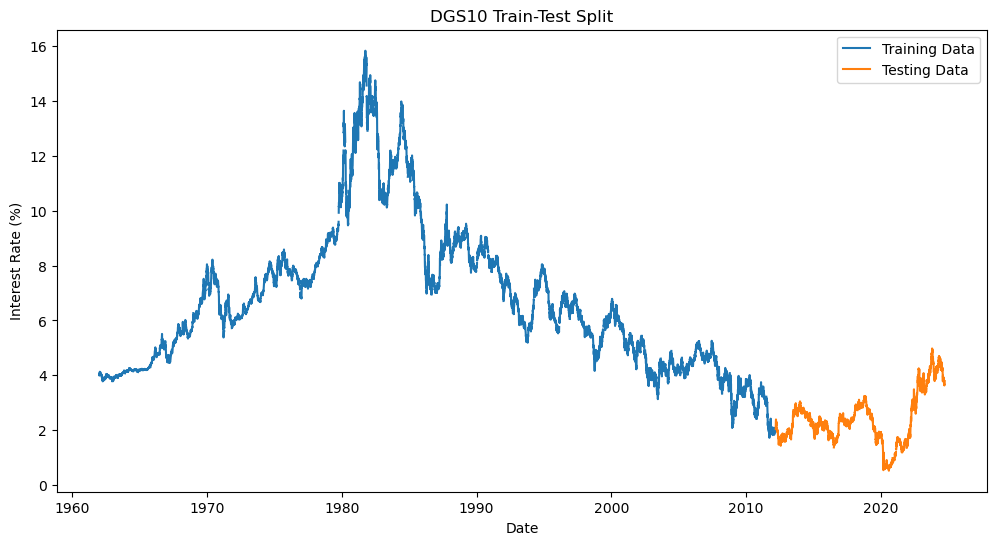

In [43]:
# Sort the data by date to ensure chronological order
data = data.sort_values('Date')

# Define the split point (e.g., use the last 20% of the data for testing)
split_point = int(len(data) * 0.8)

# Split the data
train_data = data.iloc[:split_point]
test_data = data.iloc[split_point:]

# If you need the data as numpy arrays for some models
X_train = train_data['Interest Rate'].values
X_test = test_data['Interest Rate'].values

# If you need datetime index
train_data.set_index('Date', inplace=True)
test_data.set_index('Date', inplace=True)

print(f"Training data shape: {train_data.shape}")
print(f"Testing data shape: {test_data.shape}")

# Visualize the split
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data['Interest Rate'], label='Training Data')
plt.plot(test_data.index, test_data['Interest Rate'], label='Testing Data')
plt.title('DGS10 Train-Test Split')
plt.xlabel('Date')
plt.ylabel('Interest Rate (%)')
plt.legend()
plt.show()

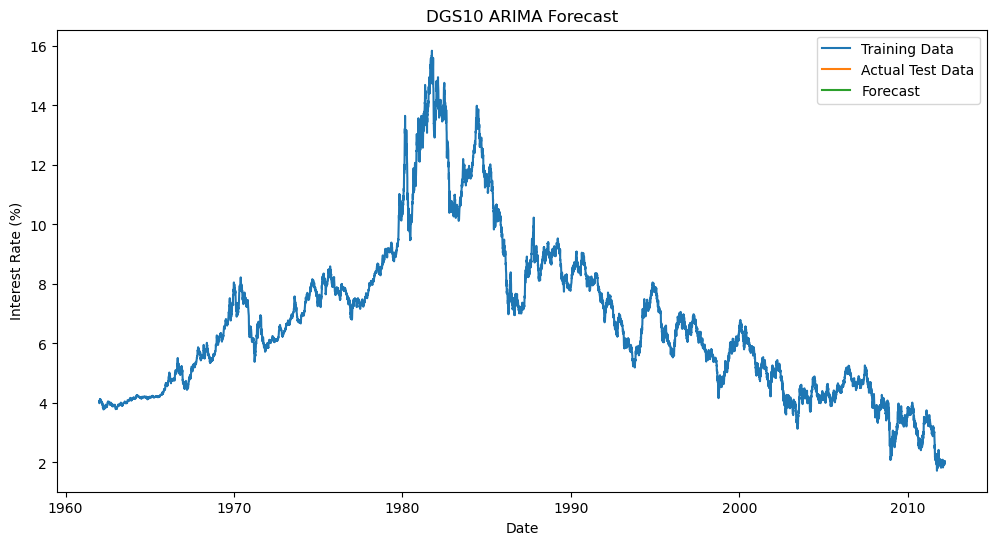

In [48]:
from sklearn.metrics import mean_squared_error

# Ensure there are no NaN values in the training and test data
train_data = train_data.dropna()
test_data = test_data.dropna()

# Fit ARIMA model
model = ARIMA(train_data['Interest Rate'], order=(1,1,1))
model_fit = model.fit()

# Forecast
forecast = model_fit.forecast(steps=len(test_data))

# Ensure forecast and test data have the same index
forecast = pd.Series(forecast, index=test_data.index)

# Align the forecast with the test data
aligned_forecast, aligned_test = forecast.align(test_data['Interest Rate'])

# Remove any remaining NaN values
mask = ~(aligned_forecast.isna() | aligned_test.isna())
aligned_forecast = aligned_forecast[mask]
aligned_test = aligned_test[mask]

# Calculate RMSE
#rmse = np.sqrt(mean_squared_error(aligned_test, aligned_forecast))
#print(f'RMSE: {rmse}')

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data['Interest Rate'], label='Training Data')
plt.plot(aligned_test.index, aligned_test, label='Actual Test Data')
plt.plot(aligned_forecast.index, aligned_forecast, label='Forecast')
plt.title('DGS10 ARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Interest Rate (%)')
plt.legend()
plt.show()